# **Modélisation et prévisions**

## Chargement des données

In [92]:
# Importer les bibliothèques nécessaires
import pandas as pd
import os 
import shap
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt


In [109]:
# Base du projet
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))  # Utiliser le répertoire de travail actuel
# Charger les données contenant les features
FEATURES_DATA_PATH = os.path.join(BASE_DIR, "data", "features")
file_path = os.path.join(FEATURES_DATA_PATH, "telecom_sales_data_features.csv")
try:
    historical_data = pd.read_csv(file_path)
    print("Données des features chargées avec succès.")
    # Vérifier les colonnes disponibles
    print("Colonnes du DataFrame :", historical_data.columns.tolist())
except FileNotFoundError:
    print(f"Fichier introuvable : {file_path}")
except Exception as e:
    print(f"Erreur lors du chargement des données : {e}")
missing_values_after = historical_data.isnull().sum()
print("erreur",missing_values_after[missing_values_after > 0])

Données des features chargées avec succès.
Colonnes du DataFrame : ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue', 'date', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 'weather_condition_Bad', 'weather_condition_Good', '5g_phase_Early-5G', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Good', 'public_transport_Hub', 'public_transport_Poor']
erreur jPhone_Pro_revenue        90
Kaggle_Pixel_5_revenue    90
Planet_SX_revenue         90
dtype: int64


In [111]:
historical_data['date'] = pd.to_datetime(historical_data['date'], errors='coerce')
if historical_data['date'].isnull().any():
    print("Les lignes avec des dates invalides sont :")
    print(historical_data[historical_data['date'].isnull()])
    raise ValueError("Des dates invalides sont présentes dans les données.")

## Modèle XGBOOST


Processing target: jPhone_Pro_revenue
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Meilleurs paramètres trouvés :
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Évaluation des performances sur l'ensemble de validation :
MAE : 15784.83
MSE : 422925238.57
RMSE : 20565.15
R² : 0.14


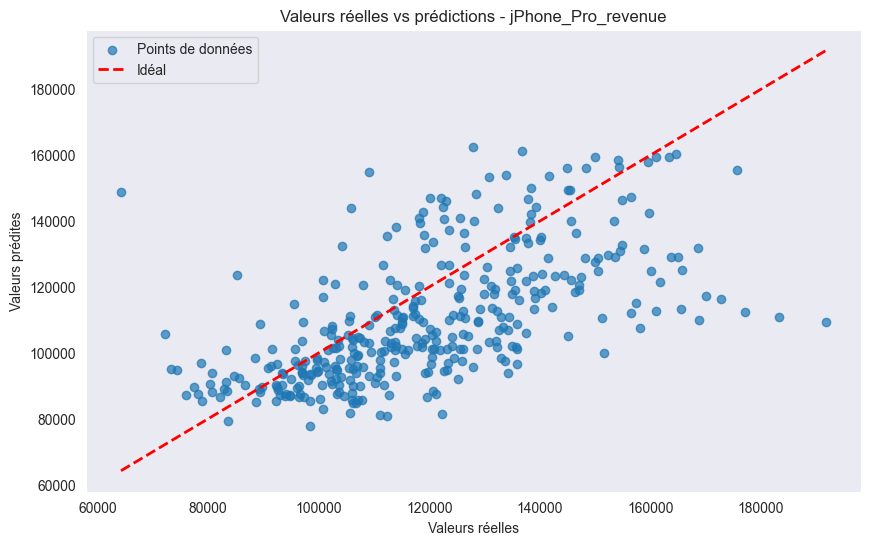

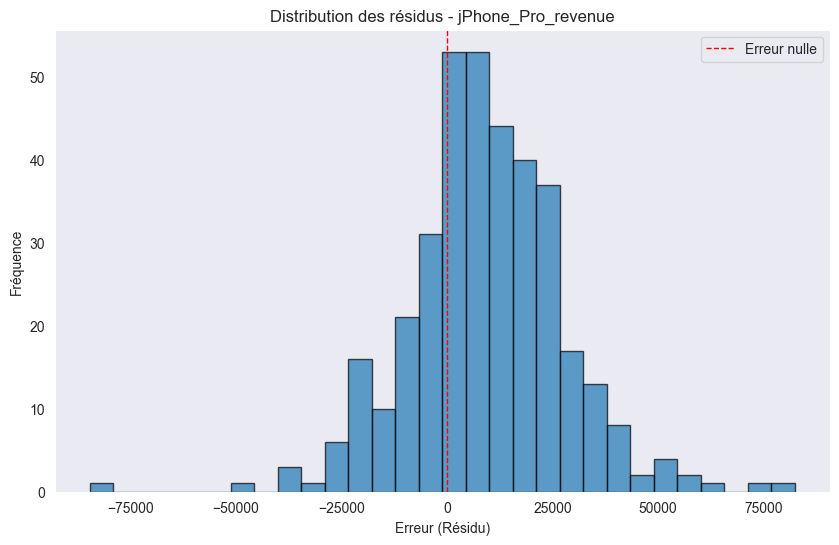


Modèle : jPhone_Pro_revenue
MAE : 15784.83
MSE : 422925238.57
RMSE : 20565.15
R² : 0.14

Processing target: Kaggle_Pixel_5_revenue
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Meilleurs paramètres trouvés :
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

Évaluation des performances sur l'ensemble de validation :
MAE : 8644.92
MSE : 131752591.15
RMSE : 11478.35
R² : 0.01


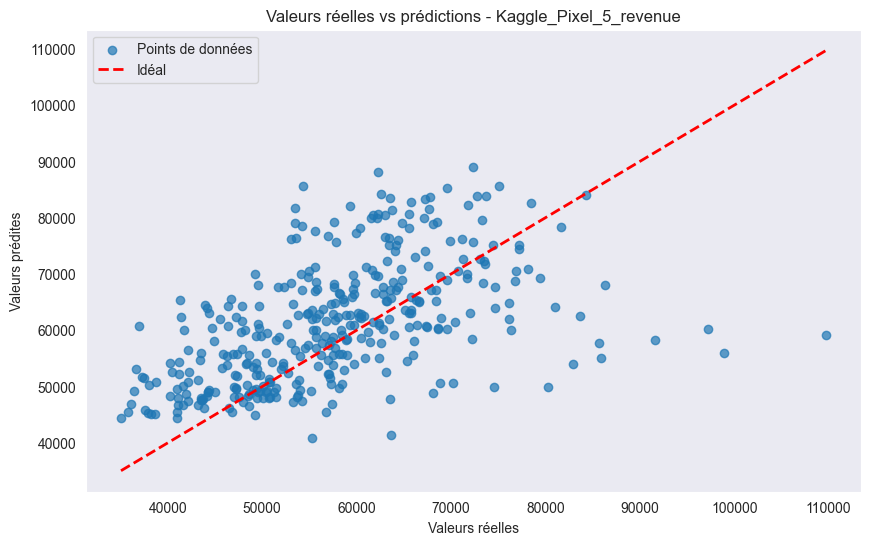

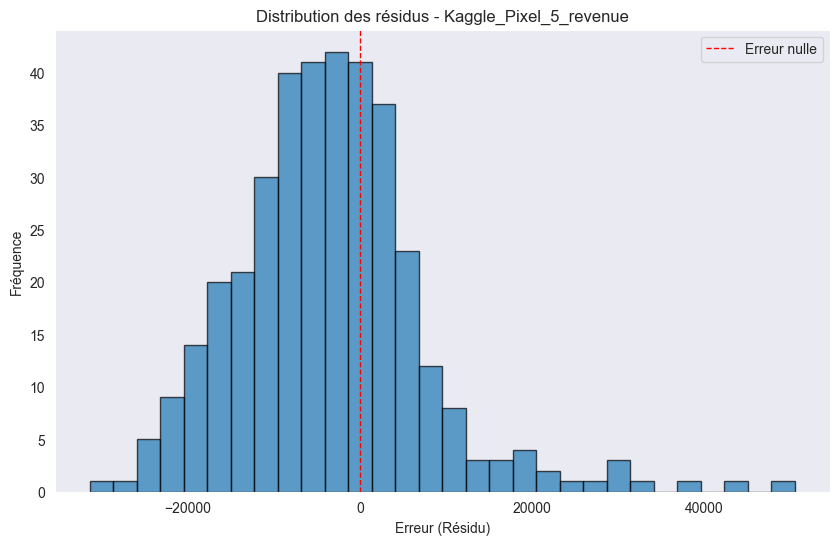


Modèle : Kaggle_Pixel_5_revenue
MAE : 8644.92
MSE : 131752591.15
RMSE : 11478.35
R² : 0.01

Processing target: Planet_SX_revenue
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Meilleurs paramètres trouvés :
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Évaluation des performances sur l'ensemble de validation :
MAE : 5691.13
MSE : 50698980.43
RMSE : 7120.32
R² : -0.39


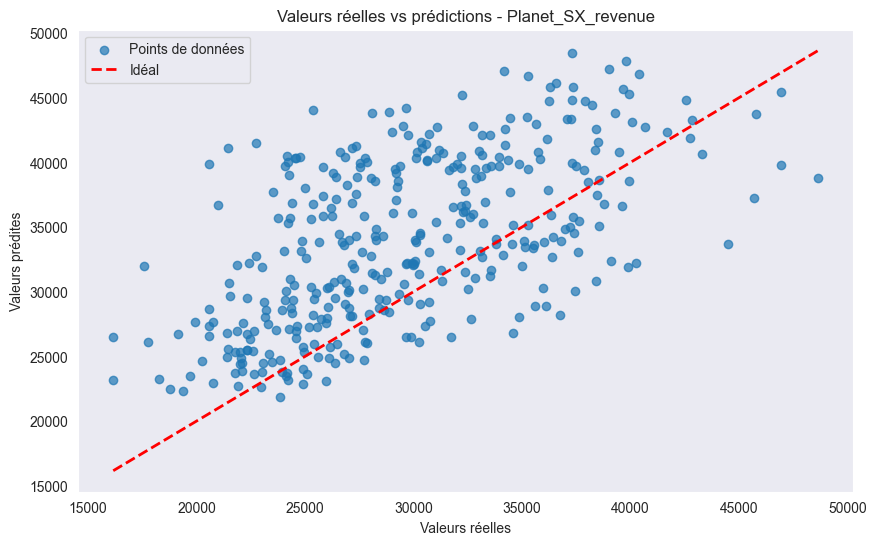

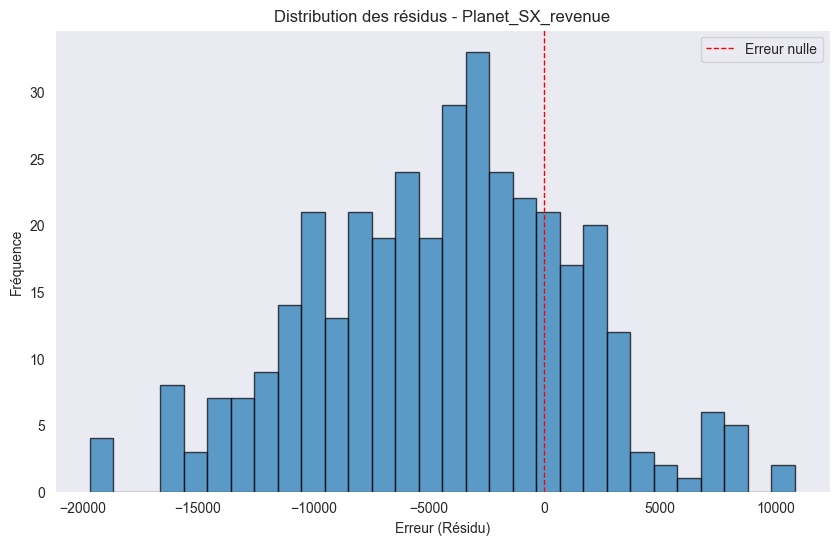


Modèle : Planet_SX_revenue
MAE : 5691.13
MSE : 50698980.43
RMSE : 7120.32
R² : -0.39


In [116]:
# Diviser les données
features = ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 
            'year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 
            'weather_condition_Bad', 'weather_condition_Good', 
            '5g_phase_Early-5G', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 
            'public_transport_Good', 'public_transport_Hub', 'public_transport_Poor']
targets = ['jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue']

# Diviser les données en train et validation
train_data = historical_data[historical_data['date'] < '2024-01-01']
validation_data = historical_data[(historical_data['date'] >= '2024-01-01') & (historical_data['date'] < '2025-01-01')]

results = {}  # Dictionnaire pour stocker les résultats pour chaque target
best_models = {}  # Dictionnaire pour stocker les meilleurs modèles pour chaque cible

# Boucle sur chaque target
for target in targets:
    print(f"\nProcessing target: {target}")
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = validation_data[features]
    y_test = validation_data[target]
    
    # Vérification et suppression des valeurs invalides dans y_train et y_test
    y_train = y_train.replace([np.inf, -np.inf], np.nan).dropna()
    y_test = y_test.replace([np.inf, -np.inf], np.nan).dropna()

    # Vérification que X_train et y_train ont la même longueur
    if len(X_train) != len(y_train):
        print(f"Avertissement : Longueurs incompatibles entre X_train et y_train pour {target}")
        continue

    # Initialiser le modèle XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Définir la grille de paramètres
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 1.0]
    }
    
    # TimeSeriesSplit pour validation croisée temporelle
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Initialiser GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        verbose=1,
        n_jobs=-1
    )
    
    # Entraîner le modèle avec validation croisée
    grid_search.fit(X_train, y_train)
    
    # Meilleurs paramètres
    print("Meilleurs paramètres trouvés :")
    print(grid_search.best_params_)
    
    # Enregistrer le meilleur modèle pour cette cible
    best_models[target] = grid_search.best_estimator_
    
    # Évaluation sur l'ensemble de validation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("\nÉvaluation des performances sur l'ensemble de validation :")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.2f}")
    
    # Stocker les résultats
    results[target] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Best Params': grid_search.best_params_,
        'Actual vs Predicted': pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    }
    
    # Visualisation des prédictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label='Points de données')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Idéal')
    plt.title(f"Valeurs réelles vs prédictions - {target}")
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Visualisation des résidus
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Distribution des résidus - {target}")
    plt.xlabel("Erreur (Résidu)")
    plt.ylabel("Fréquence")
    plt.axvline(0, color='r', linestyle='dashed', linewidth=1, label='Erreur nulle')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Impression des métriques
    print(f"\nModèle : {target}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.2f}")

In [113]:
# Convertir les colonnes booléennes en int
bool_columns = X_train.select_dtypes(include=['bool']).columns

X_train[bool_columns] = X_train[bool_columns].astype(int)
X_test[bool_columns] = X_test[bool_columns].astype(int)

print("\nTypes des colonnes après conversion des booléens :")
print(X_train.dtypes)


Types des colonnes après conversion des booléens :
marketing_score           float64
competition_index         float64
customer_satisfaction     float64
purchasing_power_index    float64
store_traffic             float64
year                        int64
month                       int64
day                         int64
day_of_week                 int64
week_of_year                int64
is_weekend                  int64
weather_condition_Bad       int32
weather_condition_Good      int32
5g_phase_Early-5G           int32
5g_phase_Mature-5G          int32
5g_phase_Mid-5G             int32
5g_phase_Pre-5G             int32
public_transport_Good       int32
public_transport_Hub        int32
public_transport_Poor       int32
dtype: object


C:\Users\etudiant\AppData\Local\Temp\ipykernel_64644\3893547403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[bool_columns] = X_train[bool_columns].astype(int)
C:\Users\etudiant\AppData\Local\Temp\ipykernel_64644\3893547403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[bool_columns] = X_test[bool_columns].astype(int)



Analyse SHAP pour la cible : jPhone_Pro_revenue
Résumé des valeurs SHAP :


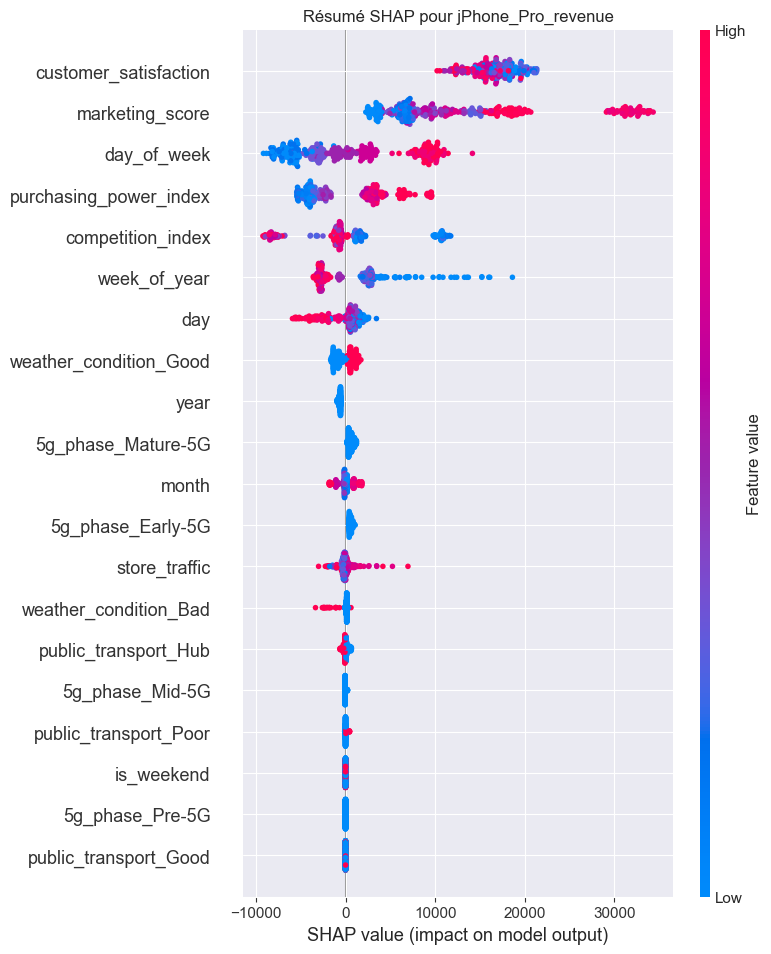

Graphique en barres de l'importance des caractéristiques :


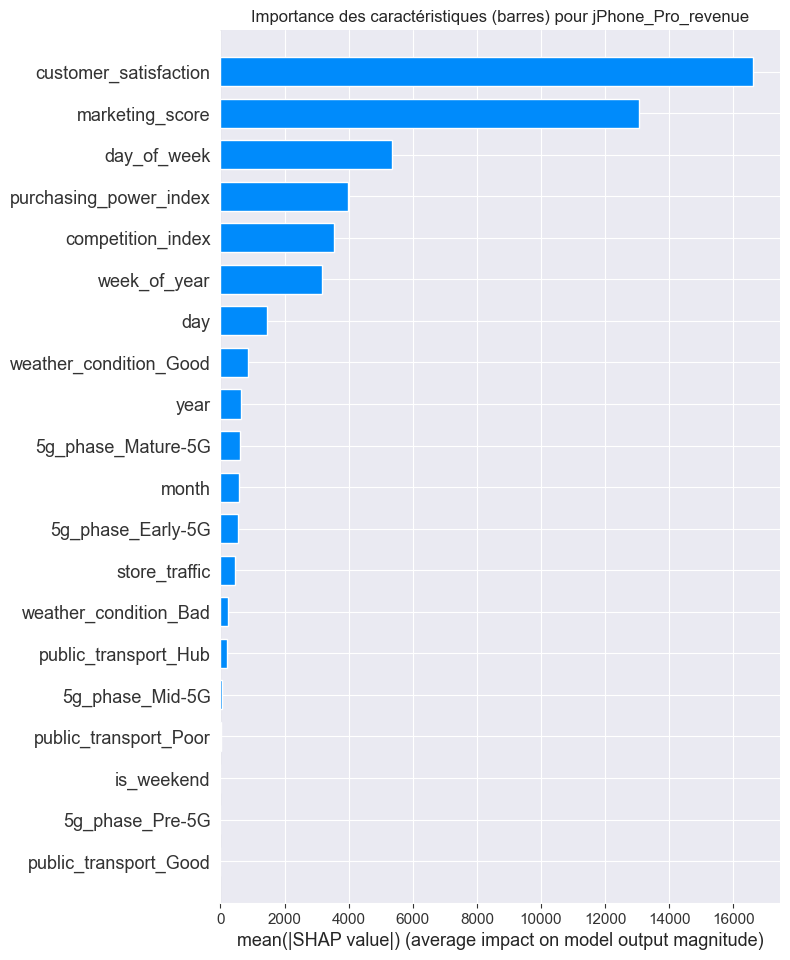


Analyse SHAP pour la cible : Kaggle_Pixel_5_revenue
Résumé des valeurs SHAP :


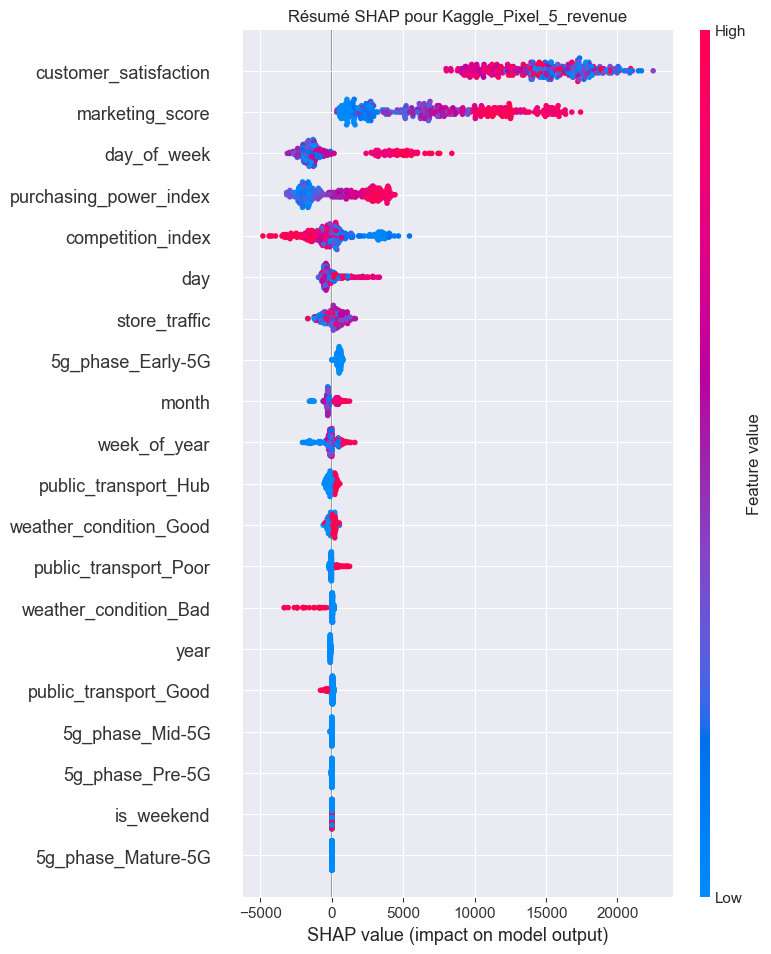

Graphique en barres de l'importance des caractéristiques :


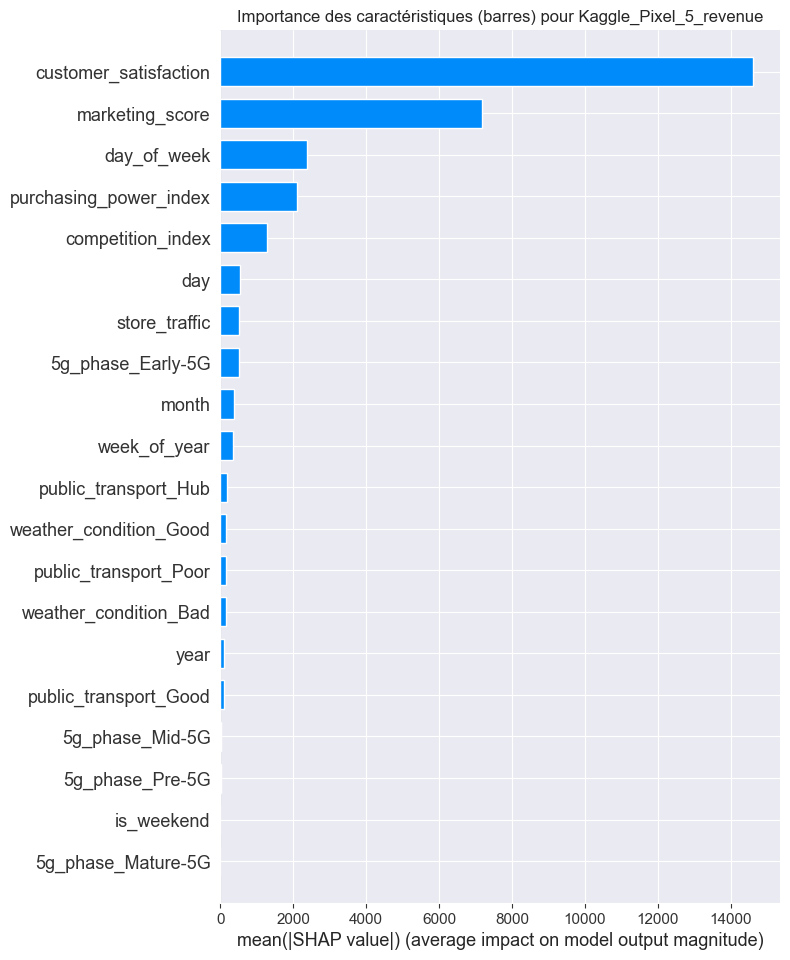


Analyse SHAP pour la cible : Planet_SX_revenue
Résumé des valeurs SHAP :


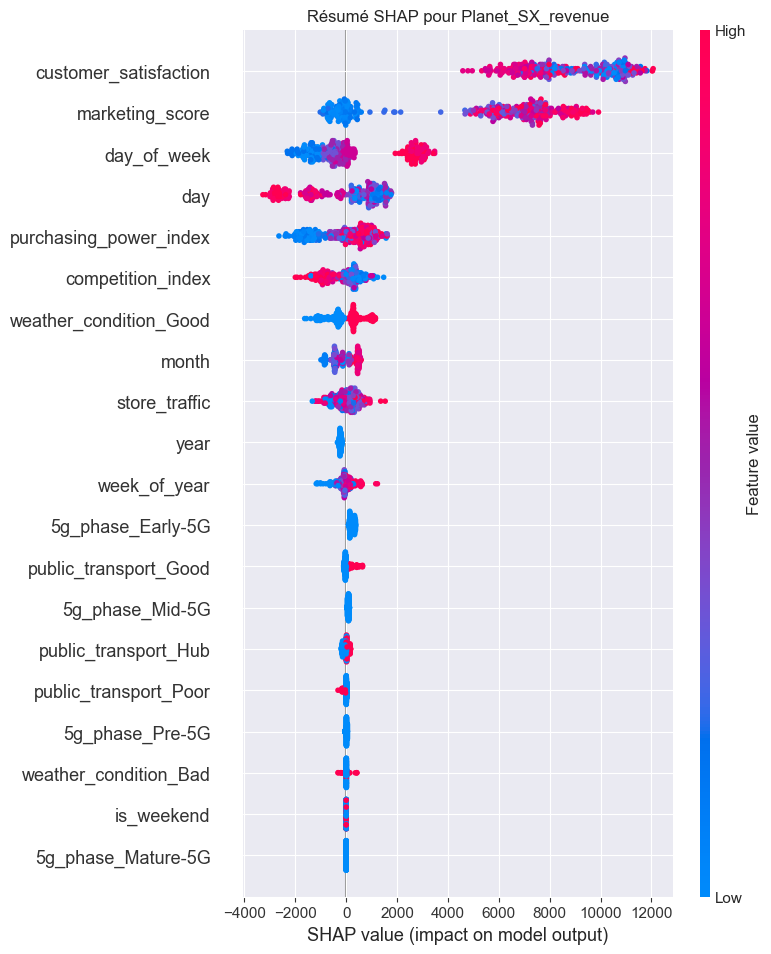

Graphique en barres de l'importance des caractéristiques :


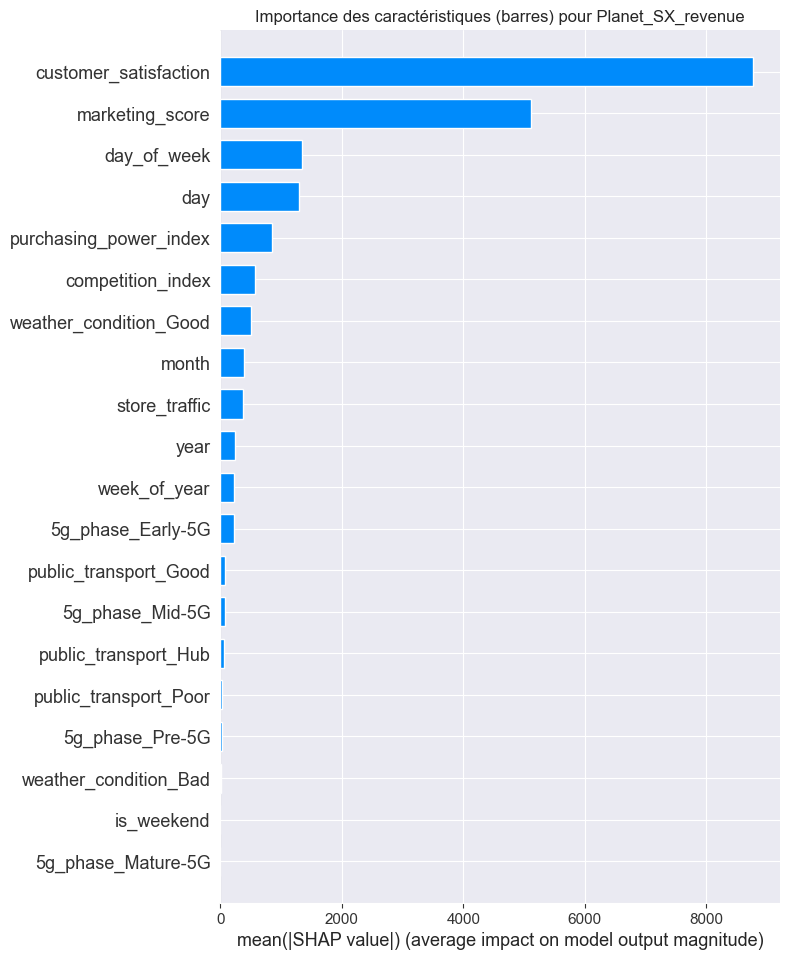

In [114]:
# Analyse SHAP pour chaque cible
for target, model in best_models.items():
    print(f"\nAnalyse SHAP pour la cible : {target}")
    
    # Préparer les données spécifiques à la cible
    X_train_target = train_data[features].copy()
    y_train = train_data[target]
    X_test_target = validation_data[features].copy()
    y_test = validation_data[target]
    
    # Vérifier et convertir les types si nécessaire
    for col in X_train_target.columns:
        if X_train_target[col].dtype == 'O':  # Type objet
            print(f"Conversion de la colonne '{col}' de type objet à float.")
            X_train_target[col] = X_train_target[col].astype(float, errors='ignore')
            X_test_target[col] = X_test_target[col].astype(float, errors='ignore')
        elif X_train_target[col].dtype == 'bool':  # Type booléen
            X_train_target[col] = X_train_target[col].astype(int)
            X_test_target[col] = X_test_target[col].astype(int)
    
    # Créer un explainer SHAP
    explainer = shap.Explainer(model, X_train_target)
    
    # Calculer les valeurs SHAP pour l'ensemble de validation
    shap_values = explainer(X_test_target)
    
    # Résumé des valeurs SHAP (summary plot)
    print("Résumé des valeurs SHAP :")
    shap.summary_plot(shap_values, X_test_target, show=False)
    plt.title(f"Résumé SHAP pour {target}")
    plt.show()
    
    # Valeurs SHAP en barres (importance moyenne des caractéristiques)
    print("Graphique en barres de l'importance des caractéristiques :")
    shap.summary_plot(shap_values, X_test_target, plot_type="bar", show=False)
    plt.title(f"Importance des caractéristiques (barres) pour {target}")
    plt.show()
